<a href="https://colab.research.google.com/github/panchalaman/Datamining/blob/main/Data_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary:
The project aims to derive valuable insights from Airbnb listing data to inform and enhance service offerings. Using comprehensive data intergration and analysis techniques, including Hadoop MapReduce and Apache Spark, we identified key trends in pricing based on location. The results offers practical recommendations for optimizing listing prices to improve competitiveness and customer satisfaction.

# 1. Introduction:
  ## 1.1 Objective:
The primary goal is to derive actionable insights from Airbnb listing data to improve service offerings by examining important attributes such as price, room type, and location.

## 1.2 Dataset:
The analysis uses a dataset comprising multiple attributes of Airbnb listings, including:


*   Price
*   Rooom type
*   Location
*   Others pertinent attributes for a detailed analysis









Original data set taken from Inside Airbnb: https://insideairbnb.com/get-the-data/

# 2. Methodology:
## 2.1 Data Processing:


1. Duplicate Removal: Duplicate were identified and removed to ensure the dataset is clean and representive.   







2. Missing Values: Imputed missing values using appropriate statistical methods to maintain data integrity.

In [ ]:
#importing libraries
import pandas as pd
import numpy as np

#load dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/panchalaman/Datamining/main/Inside%20Airbnb%20listings%20(1).csv")

# Data Cleaning: Remove duplicates and handle missing values
dataset.drop_duplicates(inplace = True)
dataset.fillna({
    'reviews_per_month': 0,
    'last_review': '2000-01-01',
    'license' : 'Not Provided'
}, inplace = True)


3. Data Conversion: Transformed data fields to standard datetime formats for consistency and ease of analysis.

In [ ]:
dataset['last_review']=pd.to_datetime(dataset['last_review'])


4. Price Normalization: Ensured all price values are non-negative and appied normalization techniques where necessary.

In [ ]:
dataset['price']= dataset ['price'].apply (lambda x : x if x >=0 else 0)

#save preprocessed data
dataset.to_csv("preprocessed_data.csv", index = False)
print("Preprocessed data saved as 'preprocessed_data.csv'")

Preprocessed data saved as 'preprocessed_data.csv'


# 3. Hadoop MapReduce Implemetation:
  ## 3.1 Schema Mapping:

1.   Mapper: Extracts relevant fields and emits neighbourhood_group and price pairs.
2.   Reducer: Aggregates prices by neighbourhood_group and computes the average price.

    
    Mapper (mapper.py):



In [ ]:
import sys
for line in sys.stdin:
  data=line.strip().split(',')
  if len(data)==18:
    id, name, host_id, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365, number_of_reviews_ltm, license = data
    try:
      price = float(price)
      print(f"{neighbourhood_group}\t{price}")
    except ValueError:
      continue
print(dataset.head(5))

      id                                           name  host_id  \
0   3176                Fabulous Flat in great Location     3718   
1   9991            Geourgeous flat - outstanding views    33852   
2  14325            Studio Apartment in Prenzlauer Berg    55531   
3  16644             In the Heart of Berlin - Kreuzberg    64696   
4  17904  Beautiful Kreuzberg studio - 3 months minimum    68997   

        host_name       neighbourhood_group             neighbourhood  \
0          Britta                    Pankow   Prenzlauer Berg Südwest   
1         Philipp                    Pankow   Prenzlauer Berg Südwest   
2  Chris + Oliver                    Pankow  Prenzlauer Berg Nordwest   
3            Rene  Friedrichshain-Kreuzberg     nördliche Luisenstadt   
4        Matthias                  Neukölln              Reuterstraße   

   latitude  longitude        room_type  price  minimum_nights  \
0  52.53471   13.41810  Entire home/apt   83.0              63   
1  52.53269   13.418

    Reducer (reducer.py):

In [ ]:
current_ngroup = None
current_count= 0
current_total_price = 0
avg_price =0

for line in sys.stdin:
    n_group, price = line.strip().split('\t')
    try:
      price = float(price)
    except ValueError:
      continue

    if current_ngroup == n_group:
      current_total_price += price
      current_count += 1
    else:
      if current_ngroup:
          avg_price = current_total_price / current_count
          print(f"{current_ngroup}\t{avg_price}")
      current_ngroup =n_group
      current_total_price = price
      current_count = 1

if current_ngroup:
  avg_price = current_total_price/ current_count
  print(f"{current_ngroup}\t {avg_price}")



Running the Hadoop Job:

    hadoop jar /path/to/hadoop-streaming.jar\
    -input /path/to/preprocessed_data.csv\
    -output /path/to/output\
    -mapper "python3 /path/to/mapper.py"\
    -reducer "python3 /path/to/reducer.py

# 4. Apache Spark Implementation (PySpark):


Conduted efficient data processing and performed the same calculation using Apache Spark to compare witht the Hadoop MapReduce implementation:


1. Leading Data: Loaded preprocessed data into a Spark DataFrame.
2. Transformation: Grouped data by neighbourhood group and calculated the average price for each.

In [56]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

#intialize Spark session
spark = SparkSession.builder \
        .appName("Airbnb Data Integration")\
        .getOrCreate()
#Loading preprocessed data
df = spark.read.csv ("preprocessed_data.csv", header = True, inferSchema = True)

#Data transformation: calculated average price per neighbourhood group
avg_price_df = df.groupBy("neighbourhood_group").agg(avg("price").alias("avg_price"))
#persist results to colab

avg_price_df.write.mode('overwrite').csv('output/avg_price_per_neighbourhood_groups.csv',header = True)
print("Spark processing complete. Results saved to 'output/avg_price_per_neighbourhood_group.csv")




Spark processing complete. Results saved to 'output/avg_price_per_neighbourhood_group.csv


#5. Evaluation and Visualisation:
Utilize Python libraries to load and visualise the results.


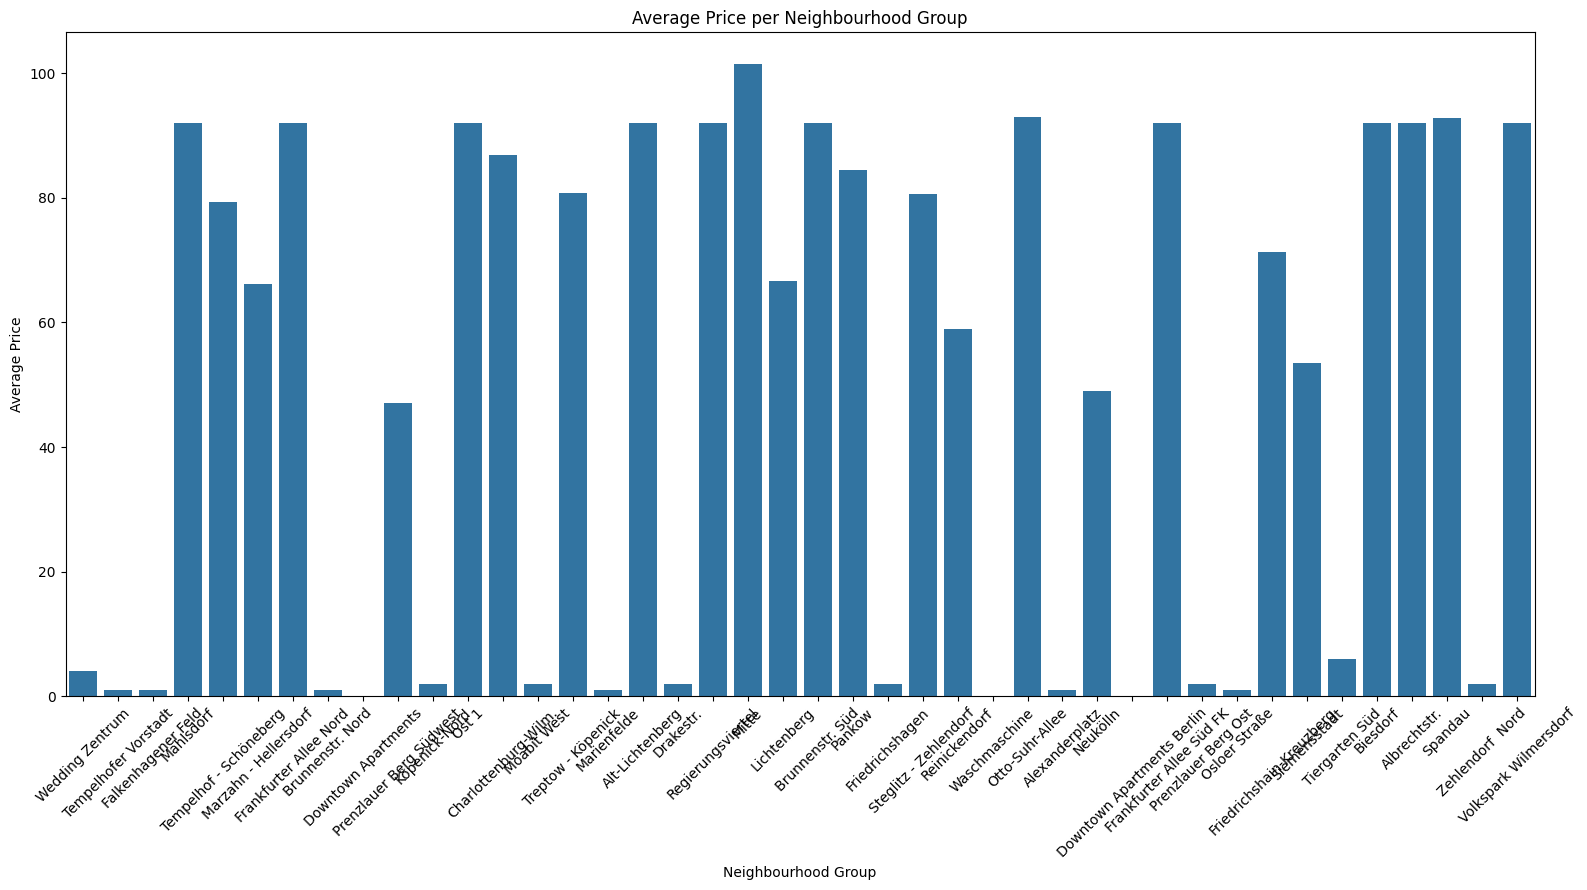

Visualisation complete. Plot saved as 'avg_price_per_neighbourhood_group.png


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
#load result data

result_data = pd.read_csv ("/content/output/avg_price_per_neighbourhood_groups.csv/part-00000-23a22fb6-1802-47f1-88af-3b0b9843beaa-c000.csv")

#plot average prices by neighbourhood group
plt.figure(figsize=(16,9))
sns.barplot(x='neighbourhood_group', y= 'avg_price', data =result_data)
plt.title("Average Price per Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig("avg_price_per_neighbourhood_group.png")
plt.show()
print("Visualisation complete. Plot saved as 'avg_price_per_neighbourhood_group.png")


# 6. Findings:


*   Average price insights per neighbourhood group
*   Notable trends in pricing based on location



#7. Conclusion:
The calculated average price gives a clear view of which neighbourhood groups are more expensive or affordable. This information can be used to understand market trends and price disparities across different area.

# 8. Business Insights:
1. Neighbourhoods with higher average prices may indicate high demand or a higher standard of living, which might be attractive to more affluent visitors and investors.
2. Hosts in more affordable neighbourhood could consider adjusting their prices to be more competitive based on the average prices in their area. Conversely, hosts in high-priced areas might leverage their premium to offer more luxury services or amenities.
3. Marketing efforts could be tailored based on the average prices. High-cost areas might benefit from luxury-focused marketing,whereas more affordable areas could target budget-friendly messages.

# 9. Github Repository Link:
https://github.com/panchalaman/Datamining/blob/main/Inside%20Airbnb%20listings%20(1).csv
